In [6]:
!pip install wordcloud

In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as func

spark = SparkSession.builder\
        .master("local")\
        .appName("Model")\
        .config('spark-master', '7077')\
        .config("spark.cleaner.referenceTracking.cleanCheckpoints", "true")\
        .getOrCreate()

In [9]:
from functools import reduce
from pyspark.sql import DataFrame

parquetFile = spark.read.parquet("hdfs://namenode:9000/hadoop/dfs/data/review/") 
parquetFile.createOrReplaceTempView("tiki_review_data")

In [12]:
parquetFile = spark.read.parquet("hdfs://namenode:9000/hadoop/dfs/data/item/") 
parquetFile.createOrReplaceTempView("tiki_item_data")

# EDA cho review data

In [13]:
review_df = spark.sql("""
SELECT * FROM tiki_review_data
""")

In [17]:
import matplotlib.pyplot as plt

In [18]:
review_df

DataFrame[review: string, __index_level_0__: bigint, rating: int]

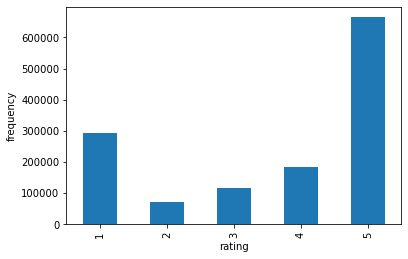

In [19]:
fig,ax = plt.subplots()
review_df.toPandas()["rating"].value_counts().sort_index().plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = "rating")
fig.show()

In [20]:
comment_words = ''
stopwords = set(STOPWORDS)
 
for index, row in review_df.toPandas().iterrows():
    review = str(row["review"])
    rating = int(row["rating"])
    if rating != 1: continue
 
    tokens = review.split(" ")
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

NameError: name 'STOPWORDS' is not defined

# EDA cho item data

In [ ]:
item_df = spark.sql("""
SELECT * FROM tiki_item_data
""")

# fillna
item_df = item_df.fillna("no information", subset = ["item", "seller", "category", "brand"])
item_df = item_df.fillna(0, subset = ["rating_value", "review_count"])
item_df = item_df.dropna(subset = ["price"])

In [ ]:
item_df.show()

## Các loại sản phẩm phổ biến nhất

In [ ]:
fig,ax = plt.subplots()
item_df.toPandas()["category"].value_counts()[:5].plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = "Loại sản phẩm")
fig.show()

## Giá trị trung bình theo category

In [ ]:
fig,ax = plt.subplots()

average_price_by_category = item_df.groupBy("category").agg(F.mean("price").alias("average_price")).orderBy("average_price", ascending = False)
average_price_by_category.toPandas().set_index("category").plot(ax = ax, kind = 'bar', ylabel = 'Giá trị trung bình', xlabel = "Loại sản phẩm")

fig.show()

## Lượng review theo brand -> có thể tìm ra brand nào nhận được nhiều review nhất

In [ ]:
fig,ax = plt.subplots()

review_numbers_by_brand = item_df.groupBy("brand").agg(F.sum("review_count").alias("total_review_count"))\
.orderBy("total_review_count", ascending = False)
review_numbers_by_brand.toPandas()[:10].set_index("brand").plot(ax = ax, kind = 'bar', ylabel = 'Tổng số review', xlabel = "Tên hãng")

fig.show()

## Giá trị sản phẩm trung bình theo brand -> có thể nhìn ra brand nào bán đồ rẻ nhất

In [ ]:
fig,ax = plt.subplots()

average_price_by_brand = item_df.groupBy("brand").agg(F.mean("price").alias("average_price"))\
.orderBy("average_price", ascending = True)
average_price_by_brand.toPandas()[:10].set_index("brand").plot(ax = ax, kind = 'bar', ylabel = 'Giá trị trung bình sản phẩm', xlabel = "Tên hãng")

fig.show()